# Spectral Match Filter Detection Tutorial With Hyperspectral Data

Example of using PlantCV tools with a Spectral Match Filter Detection Tool from the GatorSense HSI Toolkit https://github.com/GatorSense/hsi_toolkit_py. In this example we identify spectra for training the SMF detector. Then use the identified spectra for detection on the original image used for training (in a real example you would use these parameters on test images). You would not run this workflow in parallel as it is. There are steps here that  make it easier to develop a workflow but that do not make sense to run in parallel. This notebook would also likely be run in two parts. Part one: Identification of spectra for matching. Part 2: Detection using SMF on one image. Here we're showing detection on just the training image for demonstration purposes. 

Updated: September, 2025

Updated by Haley Schuhl

In [1]:
# Set the notebook display method
# If widget is not working, then change to inline
%matplotlib widget


In [ ]:
# Import required software packages
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs

from hsi_toolkit.signature_detectors.smf_detector import smf_detector
import numpy as np
import cv2


# Print out the version of PlantCV being used by the Jupyter kernel
pcv.__version__

'4.10.dev141+g4d773a24e'

In [3]:
# Input/output options
args = WorkflowInputs(
    images=["./img/training_burk.raw"],
    names="image1",
    result="hyperspectral_result",
    outdir=".",
    writeimg=True,
    debug="plot"
    )

In [4]:
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Change display settings
pcv.params.dpi = 100
pcv.params.text_size = 20
pcv.params.text_thickness = 20

# Part 1: Identify Spectra For Training

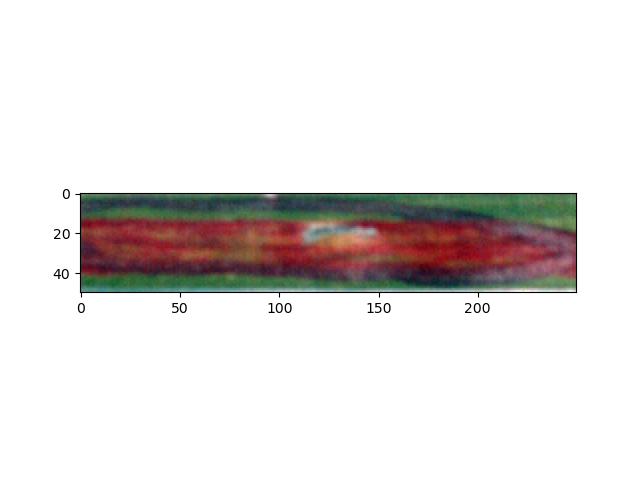

In [5]:
# read hyperspectral image. With the ENVI format the input file should be a .raw. 
# This is sorghum infected with Burkholderia (6 days post infection)
training_hyper = pcv.readimage(filename=args.image1, mode='envi')

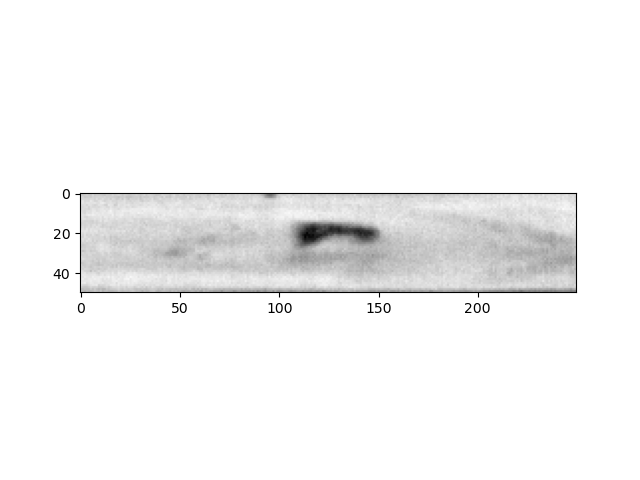

In [6]:
# Calculate the Carotenoid Index from the datacube To Segement leaf section

index_array_savi  = pcv.spectral_index.savi(hsi=training_hyper, distance=5)


In [7]:
#plot histogram of data to more easily select a threshold. 
# Please note this step would not be included in a workflow when run in parallel

hist_figure1= pcv.visualize.histogram(index_array_savi.array_data, bins=30)

alt.Chart(...)

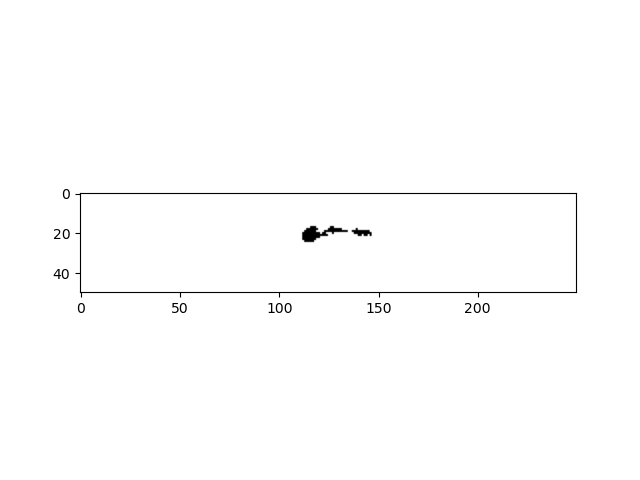

In [8]:
# Select a threshold value that isolates your target object well. If necessary do additional steps to clean up the mask.

savi_thresh = pcv.threshold.binary(gray_img=index_array_savi.array_data, threshold=.3)

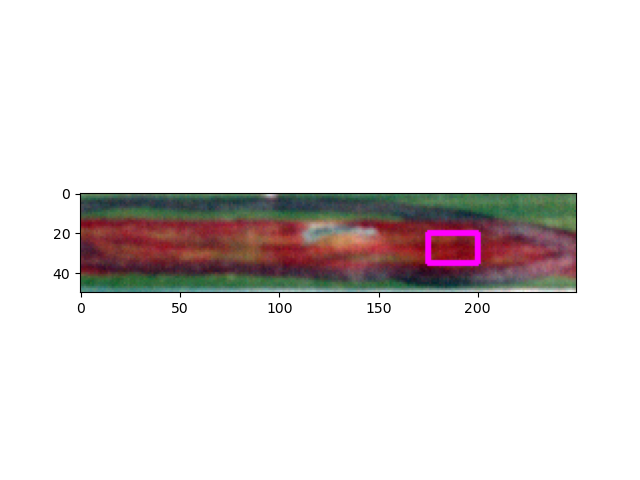

In [9]:
#Select a custom area which will be the spectra that will be matched. Here we are only selecting one area but you can also select multiple areas for matching, or multiple images.

pcv.params.line_thickness = 2

roi = pcv.roi.custom(img=training_hyper.pseudo_rgb, vertices=[[175,20],[175,35],[200,35],[200,20]])

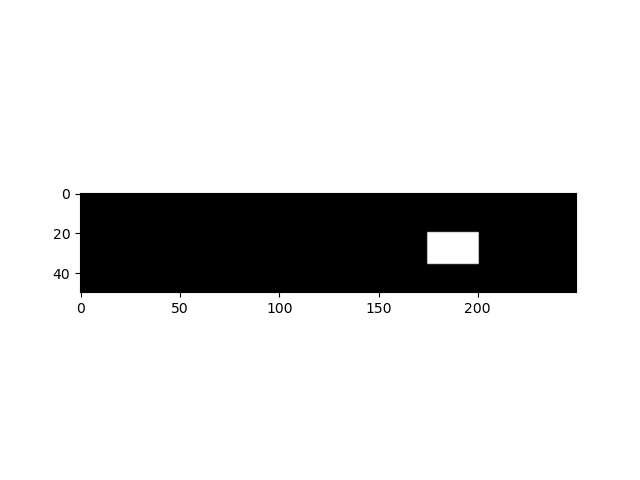

In [10]:
# Make cut the total plant area to that specific ROI

training_mask = pcv.roi.filter(mask=savi_thresh, roi=roi, roi_type='cutto')

In [11]:
#Find the spectra of that custom ROI area

train_hist  = pcv.analyze.spectral_reflectance(hsi=training_hyper, labeled_mask=training_mask, n_labels=1, label="burk-train")

alt.FacetChart(...)

In [12]:
# The wavelength means are needed as input for the spectral match filter below. The data needs to be in an array format. There is are other observations associated with the hyperspectral output data

train_data = pcv.outputs.observations["burk-train_1"]['wavelength_means']['value']
train_data_burk = np.array(train_data) 

# Part 2: Spectral Match Filter Detection

# Test the SMF Detector on the Original Image to decide on parameters (positive control)

## Once you decided on the parameters you would follow the same steps below on a test image

In [13]:
#Apply SMF detector to the image used for training
heatmap_6dpi_trainburk, mu_6dpi_testburk, sig_inv_6dpi_testburk = smf_detector(training_hyper.array_data, train_data_burk, mu=None, sig_inv=None)

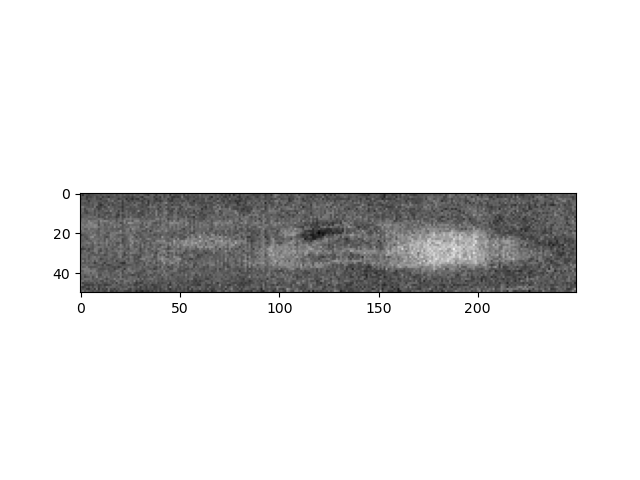

In [14]:
#Plot the probablity heatmap
pcv.plot_image(heatmap_6dpi_trainburk)

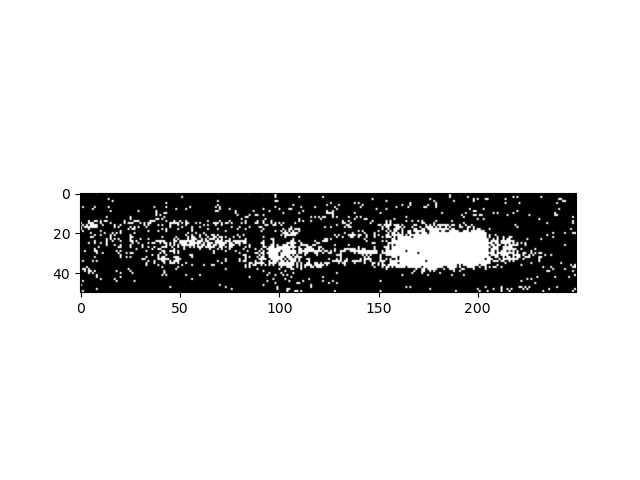

In [15]:
# Threshold the heatmap so that detectable area 'looks good' (this is a positive control)
detect_train_burk = pcv.threshold.binary(gray_img=heatmap_6dpi_trainburk, threshold=0.7)

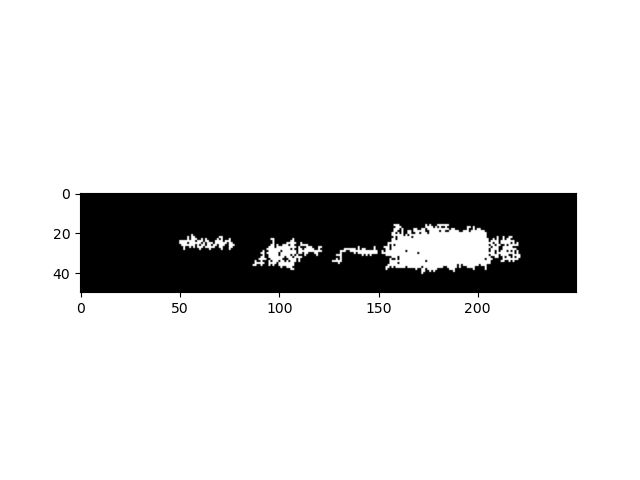

In [16]:
# Fill the binary threshold so that detectable area 'looks good' (this is a positive control). You will use the same threshold and fill values for the test images

fill_trainburk = pcv.fill(detect_train_burk, 20)

In [17]:
# Percent of Total Plant Area with Burkholderia Infection
percent_infection_trainingburk = (np.sum(fill_trainburk)/np.sum(savi_thresh))*100
percent_infection_trainingburk

np.float64(11.675004034210101)

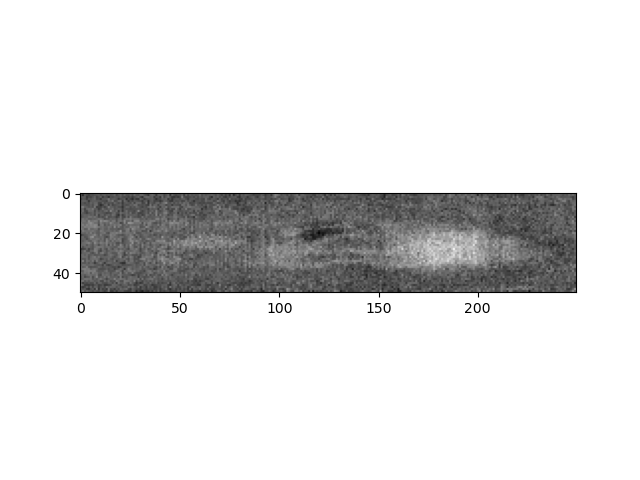

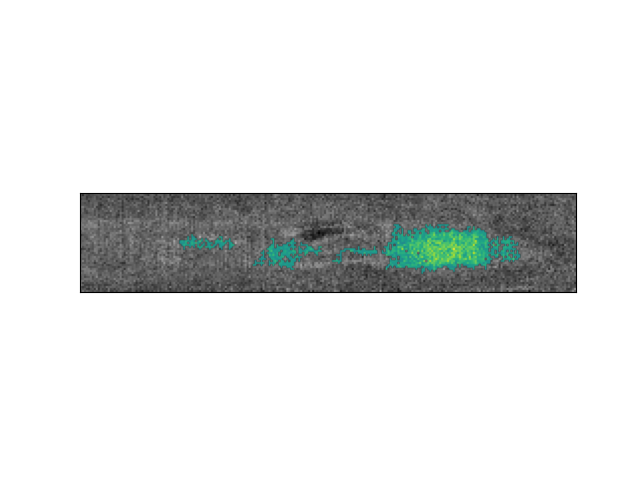

In [18]:
scaled_img = pcv.transform.rescale(gray_img=heatmap_6dpi_trainburk, min_value=0, max_value=255)

simple_pseudo_img = pcv.visualize.pseudocolor(gray_img=scaled_img, mask=fill_trainburk,
                                              background="image", axes=False,
                                              colorbar=False, cmap='viridis')